In [45]:
import pandas  as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error,mean_squared_error
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_theme()


In [46]:
df=pd.read_csv("D:\\INSEA\\Stage PFA\\Stage Ministère de finance\\data\\tourism\\TES+marrakech_lag_1.csv" )
#df=df[['date','TES']]
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df = df.asfreq('MS')  # MS = Month Start
df = df.sort_index()

In [ ]:
# df=df[:180]

In [4]:
#df=df[:120]

## EDA

In [5]:
# df['Date'] = pd.to_datetime(df['Date'])

# # Créer la plage de dates manquantes pour 2020 (12 mois)
# missing_2020 = pd.date_range(start='2020-01-01', end='2020-12-01', freq='MS')

# # Créer un DataFrame avec les dates manquantes et valeur 0
# df_missing = pd.DataFrame({'Date': missing_2020, 'value': 0})

# # Fusionner avec ton DataFrame d'origine
# df_full = pd.concat([df, df_missing], ignore_index=True)
# df_full = df_full.sort_values('Date').reset_index(drop=True)
# df_full=df_full.drop('value',axis=1)
# df=df_full

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 184 entries, 2010-01-01 to 2025-04-01
Freq: MS
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TES              184 non-null    float64
 1   marrakech_lag_1  183 non-null    float64
dtypes: float64(2)
memory usage: 4.3 KB


In [7]:
df.describe()

,TES,marrakech_lag_1
count,180.000000,179.000000
mean,439800.388889,59.307263
std,184553.886930,14.087627
min,0.000000,22.000000
25%,379316.500000,52.000000
50%,465730.500000,58.000000
75%,527615.250000,69.000000
max,871449.000000,100.000000


In [8]:
# Graphique interactif
fig = px.line(
    df,
    x=df.index,
    y='TES',  # remplace 'value' par le nom réel de ta colonne
    title='Évolution mensuelle des arrivées des touristes étrangers de séjour (TES)',
)

# Personnalisation du style
#fig.update_traces(line=dict(color='sky blue', width=2), opacity=0.8)

fig.show()

In [9]:
s = pd.to_numeric(df['TES'], errors="coerce").dropna()
nbins = 30

counts, edges = np.histogram(s, bins=nbins)
w = edges[1] - edges[0]
xbar = (edges[:-1] + edges[1:]) / 2

x = np.linspace(s.min(), s.max(), 400)
kde_counts = gaussian_kde(s)(x) * len(s) * w

fig = go.Figure([
    go.Bar(x=xbar, y=counts, width=w, marker_color="#9AC2F7", marker_line=dict(color="white", width=1), name="Count"),
    go.Scatter(x=x, y=kde_counts, mode="lines",marker_color="#144E9A", line=dict(width=2), name="KDE")
])
fig.update_layout(title="Distribution de TES", xaxis_title="TES", yaxis_title="Count", template="simple_white", width=900, height=520)
fig.update_xaxes(showgrid=True)
fig.update_yaxes(showgrid=True)
fig.show()

##### Time series decomposition

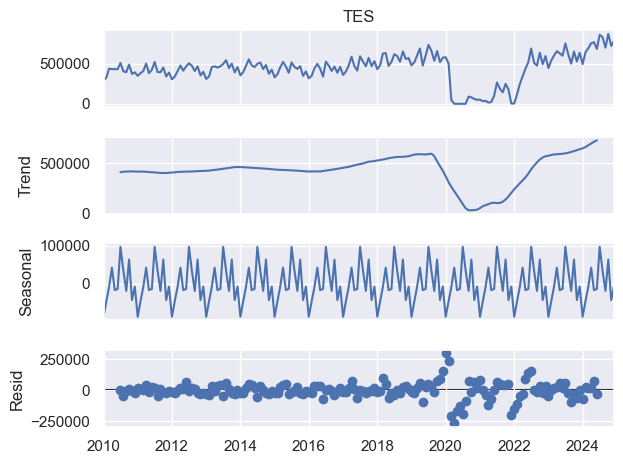

In [10]:
# Seasonal Decomposition
try:
    from statsmodels.tsa.seasonal import seasonal_decompose

    
    result = seasonal_decompose(df['TES'].dropna(), model='additive', period=12)
    result.plot()
    plt.show()
except ImportError:
    print("Statsmodels not installed. Skipping seasonal decomposition.")


#### Augmented Dickey-Fuller test

In [11]:
def test_stationnarite(serie, nom='Serie'):
    result = adfuller(serie.dropna())
    print(f'--- ADF Test fot {nom} ---')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    
    if result[1] <= 0.05:
        print("✓ Série STATIONNAIRE (p-value ≤ 0.05)")
    else:
        print("✗ Série NON-STATIONNAIRE (p-value > 0.05)")    

In [12]:
test_stationnarite(df['TES'], 'TES')

--- ADF Test fot TES ---
ADF Statistic: -2.8104
p-value: 0.0568
✗ Série NON-STATIONNAIRE (p-value > 0.05)


In [13]:
df['TES_diff1'] = df['TES'].diff()
test_stationnarite(df['TES_diff1'], 'TES_diff1')

--- ADF Test fot TES_diff1 ---
ADF Statistic: -3.0101
p-value: 0.0340
✓ Série STATIONNAIRE (p-value ≤ 0.05)


In [14]:
df['TES_diff2'] = df['TES'].diff().diff()
test_stationnarite(df['TES_diff2'], 'TES_diff1')

--- ADF Test fot TES_diff1 ---
ADF Statistic: -10.5586
p-value: 0.0000
✓ Série STATIONNAIRE (p-value ≤ 0.05)


In [15]:
df

,TES,marrakech_lag_1,TES_diff1,TES_diff2
date,,,,
2010-01-01,291608.0,NaN,NaN,NaN
2010-02-01,327017.0,56.0,35409.0,NaN
2010-03-01,437338.0,61.0,110321.0,74912.0
2010-04-01,432338.0,62.0,-5000.0,-115321.0
2010-05-01,430974.0,60.0,-1364.0,3636.0
...,...,...,...,...
2024-08-01,829406.0,79.0,-30781.0,-207593.0
2024-09-01,699434.0,85.0,-129972.0,-99191.0
2024-10-01,871449.0,81.0,172015.0,301987.0


In [16]:
ts_d1 = df['TES'].diff().dropna()
ts_d12 = ts_d1.diff(12).dropna()
print("ADF p-value (1st + seasonal diff):", adfuller(ts_d12)[1])

ADF p-value (1st + seasonal diff): 7.401412233171783e-05


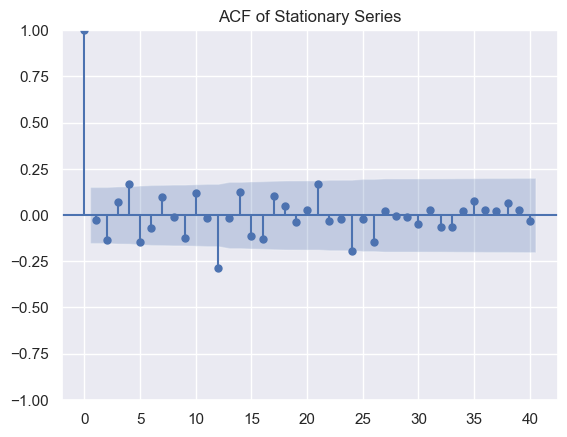

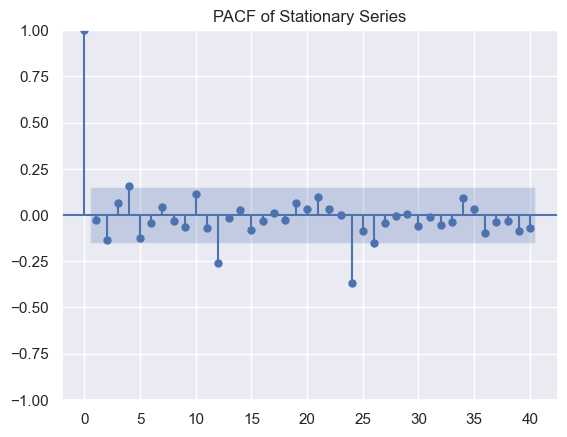

In [17]:
plot_acf(ts_d12,lags=40)
plt.title("ACF of Stationary Series")
plt.show()

plot_pacf(ts_d12,lags=40)
plt.title("PACF of Stationary Series")
plt.show()

## Modeling

In [18]:
df.isnull().sum()

TES                0
marrakech_lag_1    1
TES_diff1          1
TES_diff2          2
dtype: int64

#### Premier décomposition 

In [34]:
df

,TES,marrakech_lag_1,TES_diff1,TES_diff2
date,,,,
2010-01-01,291608.0,NaN,NaN,NaN
2010-02-01,327017.0,56.0,35409.0,NaN
2010-03-01,437338.0,61.0,110321.0,74912.0
2010-04-01,432338.0,62.0,-5000.0,-115321.0
2010-05-01,430974.0,60.0,-1364.0,3636.0
...,...,...,...,...
2024-08-01,829406.0,79.0,-30781.0,-207593.0
2024-09-01,699434.0,85.0,-129972.0,-99191.0
2024-10-01,871449.0,81.0,172015.0,301987.0


In [39]:
train=df.loc[:'11-2023']
test=df.loc['12-2023':]
print("taille du train:",len(train),"\ntaille du test :",len(test))

taille du train: 167 
taille du test : 17


#### deuxiéme decomposition

#### troisiéme décomposition

In [20]:
def grid_search_sarima(train_data, colonne='TES',
                       p_range=range(0, 2), d_range=range(1,2), q_range=range(0, 2),
                       P_range=range(0, 3), D_range=range(1, 3), Q_range=range(0, 3),
                       s=[12]):
    print("\n" + "="*70)
    print("GRID SEARCH SARIMA - VERSION OPTIMISÉE")
    print("="*70)
    # Générer toutes les combinaisons
    pdq = list(itertools.product(p_range, d_range, q_range))
    seasonal_pdq = list(itertools.product(P_range, D_range, Q_range, s))
    
    total_models = len(pdq) * len(seasonal_pdq)
    print(f"\nNombre total de modèles à tester: {total_models}")
    print("Démarrage de la recherche...\n")
    # Variables pour stocker uniquement le meilleur
    meilleur_aic = np.inf
    meilleur_modele = None
    meilleur_params = None
    meilleur_params_seasonal = None
    meilleur_bic = None
    
    compteur = 0
    modeles_testes = 0
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            compteur += 1
            
            try:
                # Ajuster le modèle
                model = SARIMAX(train_data[colonne],
                               order=param,
                               seasonal_order=param_seasonal)
                
                results = model.fit(disp=False, maxiter=200)
                modeles_testes += 1
                
                # Garder uniquement si c'est le meilleur
                if results.aic < meilleur_aic:
                    meilleur_aic = results.aic
                    meilleur_bic = results.bic
                    meilleur_modele = results
                    meilleur_params = param
                    meilleur_params_seasonal = param_seasonal
                    
                    # Afficher quand on trouve un meilleur modèle
                    print(f"  ✓ Nouveau meilleur: SARIMA{param}x{param_seasonal} - AIC: {results.aic:.2f}")
                
                # Afficher progression
                if compteur % 10 == 0 or compteur == total_models:
                    print(f"  Progression: {compteur}/{total_models} combinaisons testées ({modeles_testes} réussies)...")
                
            except Exception as e:
                # Ignorer les modèles qui ne convergent pas
                continue
    
    # Vérifier qu'au moins un modèle a convergé
    if meilleur_modele is None:
        raise ValueError("❌ Aucun modèle n'a convergé ! Essayez avec des plages de paramètres différentes.")
    
    print("\n" + "="*70)
    print("🏆 MEILLEUR MODÈLE TROUVÉ")
    print("="*70)
    print(f"SARIMA{meilleur_params}x{meilleur_params_seasonal}")
    print(f"AIC: {meilleur_aic:.2f}")
    print(f"BIC: {meilleur_bic:.2f}")
    print(f"\nModèles testés avec succès: {modeles_testes}/{total_models}")
    
    return {
        'params': meilleur_params,
        'seasonal_params': meilleur_params_seasonal,
        'aic': meilleur_aic,
        'bic': meilleur_bic,
        'model': meilleur_modele
    }

#####  optimal orders

In [21]:
def grid_search_sarima(train_data, colonne='TES',
                       p_range=range(0, 2), d_range=range(1,2), q_range=range(0, 2),
                       P_range=range(0, 3), D_range=range(1, 3), Q_range=range(0, 3),
                       s=[12], n_splits=5, metric='rmse'):
    import numpy as np
    import itertools
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    
    print("\n" + "="*70)
    print("GRID SEARCH SARIMA - EXPANDING WINDOW CV")
    print("="*70)
    
    # Générer toutes les combinaisons
    pdq = list(itertools.product(p_range, d_range, q_range))
    seasonal_pdq = list(itertools.product(P_range, D_range, Q_range, s))
   
    total_models = len(pdq) * len(seasonal_pdq)
    print(f"\nNombre total de modèles à tester: {total_models}")
    print(f"Validation croisée: {n_splits} splits")
    print(f"Métrique: {metric.upper()}")
    print("Démarrage de la recherche...\n")
    
    # Variables pour stocker uniquement le meilleur
    meilleur_score = np.inf
    meilleur_params = None
    meilleur_params_seasonal = None
    
    # Préparer les données
    data = train_data[colonne].values
    n = len(data)
    test_size = n // (n_splits + 1)
    min_train_size = n - (n_splits * test_size)
    
    compteur = 0
    modeles_testes = 0
   
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            compteur += 1
            
            scores = []
            
            # Validation croisée expanding window
            for i in range(n_splits):
                train_end = min_train_size + (i * test_size)
                test_start = train_end
                test_end = test_start + test_size
                
                if test_end > n:
                    break
                
                train = data[:train_end]
                test = data[test_start:test_end]
                
                try:
                    model = SARIMAX(train, order=param, seasonal_order=param_seasonal,
                                   enforce_stationarity=False, enforce_invertibility=False)
                    fitted = model.fit(disp=False, maxiter=200)
                    pred = fitted.forecast(steps=len(test))
                    
                    if metric == 'rmse':
                        score = np.sqrt(np.mean((test - pred) ** 2))
                    elif metric == 'mae':
                        score = np.mean(np.abs(test - pred))
                    elif metric == 'mape':
                        score = np.mean(np.abs((test - pred) / test)) * 100
                    elif metric == 'aic':
                        score = fitted.aic
                    elif metric == 'bic':
                        score = fitted.bic
                    else:
                        score = np.sqrt(np.mean((test - pred) ** 2))
                    
                    scores.append(score)
                except:
                    scores.append(np.inf)
            
            # Score moyen sur tous les splits
            avg_score = np.mean(scores) if scores else np.inf
            
            if avg_score < np.inf:
                modeles_testes += 1
                
                # Garder uniquement si c'est le meilleur
                if avg_score < meilleur_score:
                    meilleur_score = avg_score
                    meilleur_params = param
                    meilleur_params_seasonal = param_seasonal
                    
                    print(f"  ✓ Nouveau meilleur: SARIMA{param}x{param_seasonal} - {metric.upper()}: {avg_score:.4f}")
            
            # Afficher progression
            if compteur % 10 == 0 or compteur == total_models:
                print(f"  Progression: {compteur}/{total_models} combinaisons testées ({modeles_testes} réussies)...")
   
    # Vérifier qu'au moins un modèle a convergé
    if meilleur_params is None:
        raise ValueError("❌ Aucun modèle n'a convergé ! Essayez avec des plages de paramètres différentes.")
    
    # Entraîner le meilleur modèle sur toutes les données
    print("\nEntraînement du meilleur modèle sur toutes les données...")
    final_model = SARIMAX(data, order=meilleur_params, seasonal_order=meilleur_params_seasonal,
                         enforce_stationarity=False, enforce_invertibility=False)
    final_results = final_model.fit(disp=False, maxiter=200)
   
    print("\n" + "="*70)
    print("🏆 MEILLEUR MODÈLE TROUVÉ")
    print("="*70)
    print(f"SARIMA{meilleur_params}x{meilleur_params_seasonal}")
    print(f"Score CV ({metric.upper()}): {meilleur_score:.4f}")
    print(f"AIC (modèle final): {final_results.aic:.2f}")
    print(f"BIC (modèle final): {final_results.bic:.2f}")
    print(f"\nModèles testés avec succès: {modeles_testes}/{total_models}")
   
    return {
        'params': meilleur_params,
        'seasonal_params': meilleur_params_seasonal,
        'cv_score': meilleur_score,
        'aic': final_results.aic,
        'bic': final_results.bic,
        'model': final_results
    }

##### 1er décomposition 

In [22]:
meilleur = grid_search_sarima(train)


GRID SEARCH SARIMA - EXPANDING WINDOW CV

Nombre total de modèles à tester: 72
Validation croisée: 5 splits
Métrique: RMSE
Démarrage de la recherche...

  ✓ Nouveau meilleur: SARIMA(0, 1, 0)x(0, 1, 0, 12) - RMSE: 381806.1279
  ✓ Nouveau meilleur: SARIMA(0, 1, 0)x(0, 1, 1, 12) - RMSE: 283130.6143
  ✓ Nouveau meilleur: SARIMA(0, 1, 0)x(1, 1, 2, 12) - RMSE: 273712.8414
  Progression: 10/72 combinaisons testées (10 réussies)...
  Progression: 20/72 combinaisons testées (20 réussies)...
  ✓ Nouveau meilleur: SARIMA(0, 1, 1)x(1, 1, 2, 12) - RMSE: 251712.0021
  Progression: 30/72 combinaisons testées (30 réussies)...
  Progression: 40/72 combinaisons testées (40 réussies)...
  Progression: 50/72 combinaisons testées (50 réussies)...
  Progression: 60/72 combinaisons testées (60 réussies)...
  Progression: 70/72 combinaisons testées (70 réussies)...
  Progression: 72/72 combinaisons testées (72 réussies)...

Entraînement du meilleur modèle sur toutes les données...

🏆 MEILLEUR MODÈLE TROUVÉ
S

##### Fiting Models

In [40]:
model = SARIMAX(train["TES"],order=meilleur['params'],seasonal_order=meilleur['seasonal_params'])

In [41]:
results = model.fit(disp=False)
print(results.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                     TES   No. Observations:                  167
Model:             SARIMAX(0, 1, 1)x(1, 1, [1, 2], 12)   Log Likelihood               -1952.958
Date:                                 Thu, 30 Oct 2025   AIC                           3915.916
Time:                                         14:54:00   BIC                           3931.101
Sample:                                     01-01-2010   HQIC                          3922.084
                                          - 11-01-2023                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0700      0.077     -0.911      0.362      -0.221       0

##### Predictions

In [42]:
predictions = results.predict(start=test.index[0], end=test.index[-1])

##### Metrics

In [43]:
rmse = root_mean_squared_error(test['TES'], predictions)
r2 = r2_score(test['TES'], predictions)
mae = mean_absolute_error(test['TES'], predictions)
mape = mean_absolute_percentage_error(test['TES'], predictions)

print("="*15,"Metrics Test","="*15)
print(f"RMSE: {rmse:,.2f}")
print(f"MAE: {mae:,.2f}")
print(f"MAPE: {mape:,.2%}")
print(f"R²: {r2:,.2%}")
print(f"R²: {r2:,.4f}")

=============== Metrics Test ===============
RMSE: 179,307.41
MAE: 161,470.70
MAPE: 20.87%
R²: -177.73%
R²: -1.7773


##### Visualization


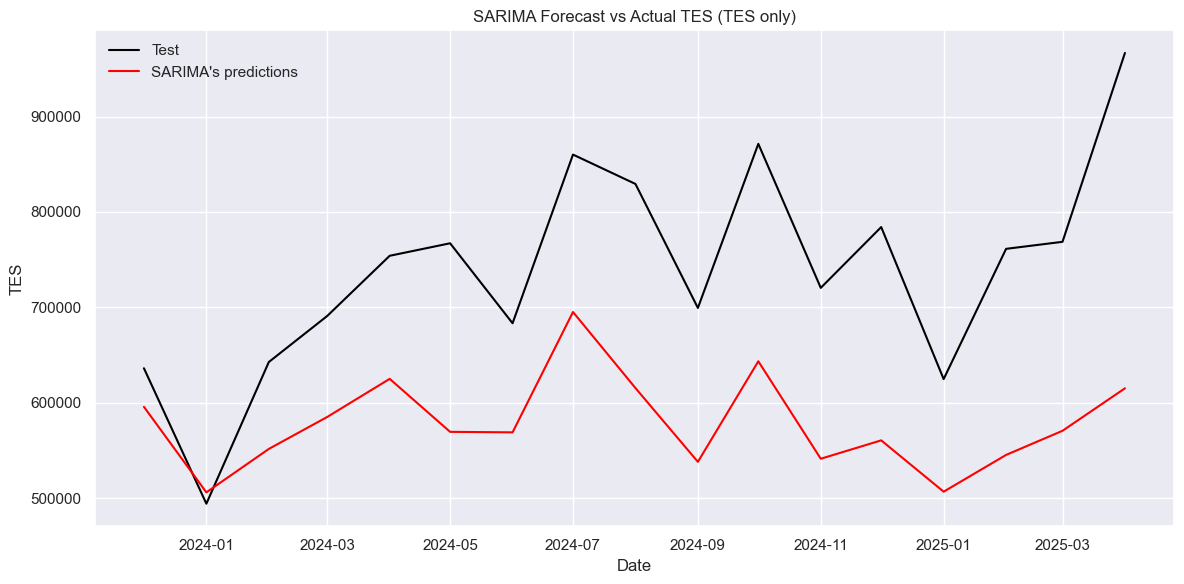

In [44]:
#Visualization
plt.figure(figsize=(12,6))
plt.plot(test.index, test['TES'], label='Test', color='black')
plt.plot(predictions.index, predictions, label='SARIMA\'s predictions', color='red')
plt.title("SARIMA Forecast vs Actual TES (TES only)")
plt.xlabel("Date")
plt.ylabel("TES")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [52]:

# Expanding window avec contraintes réelles
def forecast(df, target='TES', test=18):
    l=list(df.columns)
    l.remove('TES')
    feats = l
    train_end = len(df) - test
    preds, acts , dates = [],[], []
    
    for i in range(test):
        # Train
        print('='*40,"le test némero ",i+1,'='*40)
        train = df.iloc[:train_end + i]
        X_train, y_train = train[feats], train[target]
        model = SARIMAX(y_train,order=(0,1,0),seasonal_order=(2,2,1,12))
        results = model.fit(disp=False,maxiter=200)#, cov_type='robust')
        
        # Test avec contrainte réelle
        test_row = df.iloc[[train_end + i]][feats].copy()
        start_index = test_row.index.min()
        end_index = test_row.index.max()
        pred = results.predict(start=start_index, end=end_index, exog=test_row)[0]
        preds.append(pred)
        acts.append(df.iloc[train_end + i][target])
        dates.append(df.index[train_end + i])
    
    # Métriques
    mae = mean_absolute_error(acts, preds)
    rmse = root_mean_squared_error(acts, preds)
    r2 = r2_score(acts, preds)
    mape = 100 * np.mean(np.abs((np.array(acts) - np.array(preds)) / np.array(acts)))
    
    print("="*40,"Mrtric","="*40)
    print(f"MAE: {mae:,.1f} \nRMSE: {rmse:,.1f} \nMAPE: {mape:,.1f}%")
    print(f"R²: {r2:,.2f}")
    return pd.DataFrame({'actual': acts, 'predicted': preds} , index=dates)

# UTILISATION
# df = pd.read_csv('ventes.csv')  # Vos données
# df = prep(df, date='date', target='ventes')
# results = forecast(df, test=18)

In [53]:
results = forecast(df, test=18)

======================================== le test némero  1 ========================================
======================================== le test némero  2 ========================================
======================================== le test némero  3 ========================================
======================================== le test némero  4 ========================================
======================================== le test némero  5 ========================================
======================================== le test némero  6 ========================================
======================================== le test némero  7 ========================================
======================================== le test némero  8 ========================================
======================================== le test némero  9 ========================================
======================================== le test némero  10 ========================================

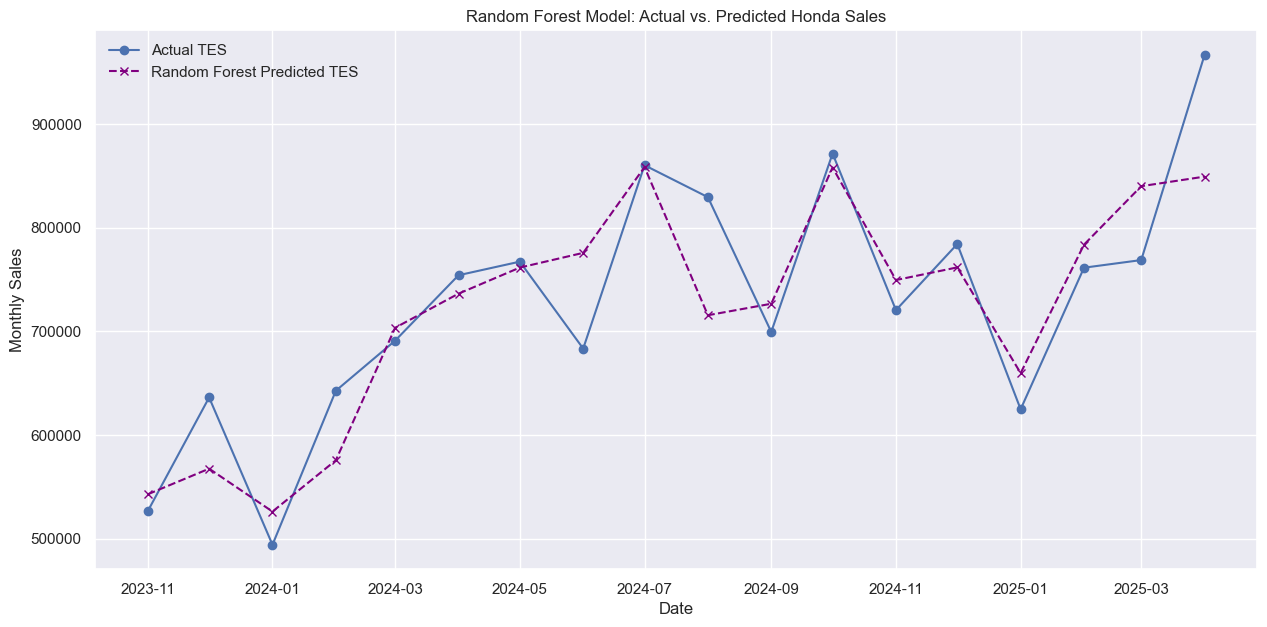

In [51]:
# Plot predictions vs. actuals
plt.figure(figsize=(15, 7))
plt.plot(results.index, results['actual'].values, label='Actual TES', marker='o', linestyle='-')
plt.plot(results.index, results['predicted'].values, label='Random Forest Predicted TES', marker='x', linestyle='--', color='purple')
plt.title('Random Forest Model: Actual vs. Predicted Honda Sales')
plt.xlabel('Date')
plt.ylabel('Monthly Sales')
plt.legend()
plt.grid(True)
plt.show()